In [1]:
import itertools

from gabriel_lego import LEGOTask
from tqdm.notebook import tqdm

import edgedroid.data as e_data
from edgedroid.models import *
from generate_corr_sequence import gen_corr_sequence
import scipy.stats as st

model = EdgeDroidModel(
    frame_trace=e_data.load_default_trace("square00", truncate=5),
    frame_model=ZeroWaitSamplingPolicy.from_default_data(),
    timing_model=MultiCurveFittingExecutionTimeModel(neuroticism=1.0)
)

task = LEGOTask(e_data.load_default_task("square00", truncate=5))


acf_50 = 1 / (2 ** np.arange(5))  # 0.5 corr
acf_25 = 1 / (4 ** np.arange(5))
acf_12 = 1 / (8 ** np.arange(5))
acf_00 = np.zeros(5)
acf_00[0] = 1.0


def emulate_run(model: EdgeDroidModel, rtt_s_iter: Iterator[float], desc: str | None = None):
    # step_iter = tqdm(model.play_steps_emulated_time(), total=model.step_count + 1, desc=desc, leave=False)

    for model_step in model.play_steps_emulated_time():
        # in this setup, we have fixed rtts per step
        step_rtt = next(rtt_s_iter)

        frame_timings: Optional[FrameTimings] = None
        prev_frame: Optional[str] = None
        while True:
            try:
                model_frame = model_step.send(frame_timings)
            except StopIteration:
                if not prev_frame or prev_frame.lower() not in ("success", "initial"):
                    raise Exception(prev_frame)
                break

            # prev_result = task.submit_frame(model_frame.frame_data)
            prev_frame = model_frame.frame_tag
            frame_timings = FrameTimings(step_rtt * 0.9, step_rtt * 0.1)

delays  = gen_corr_sequence(
    dist_obj=st.lognorm(s=1.2, loc=0.1, scale=0.1),
    L=model.step_count + 1,
    target_acf=acf_00,
    debug=False,
)

emulate_run(model, iter(delays))
model.model_step_metrics()

,last_frame_rtt,execution_time,step_duration,time_to_feedback,wait_time,frame_count
step_number,,,,,,
0,0.261879,0.000000,0.261879,0.261879,0.000000,1
1,0.199524,5.049075,5.387147,0.338073,0.138549,27
2,0.374958,5.075281,5.624376,0.549095,0.174137,15
3,0.135949,5.138659,5.301999,0.163340,0.027392,39
4,0.573163,4.644977,5.731630,1.086653,0.513490,10
5,0.245481,5.252348,5.646074,0.393725,0.148244,23


In [2]:
import itertools as it
import multiprocess as mp

trace = "square00"
truncate = 50
reps_per_model = 30
rep_offset = 0

s_param = 1.2


class ThirdDegPolyExecutionTimeModel(MultiCurveFittingExecutionTimeModel):
    _fit_functions = (CubeFit,)


timing_frame_models = {
    "3rd-poly-high": lambda: (ThirdDegPolyExecutionTimeModel(neuroticism=1.0), ZeroWaitSamplingPolicy.from_default_data()),
    "3rd-poly-low": lambda:(ThirdDegPolyExecutionTimeModel(neuroticism=0.0), ZeroWaitSamplingPolicy.from_default_data()),
    "legacy": lambda: (LegacyModel(), LegacySamplingPolicy.from_default_data()),
    "first-order": lambda: (FirstOrderETM(), ZeroWaitSamplingPolicy.from_default_data()),
    "first-order-median": lambda: (FirstOrderAggregateETM(np.median), ZeroWaitSamplingPolicy.from_default_data())
}

min_bound = 0.042  # 24FPS

rhos = (
    (0.0, acf_00),
    (0.125, acf_12),
    (0.250, acf_25),
    (0.500, acf_50),
)

scales = (
    0.05,
    0.1,
    0.2,
    0.4,
    0.8,
    1.6,
    3.2,
)

def gen_delays(params):
    rep, (rho, acf_fn), scale = params
    delays = gen_corr_sequence(
        dist_obj=st.lognorm(s=s_param, loc=min_bound, scale=scale),
        L=truncate + 1,
        target_acf=acf_fn,
        debug=False,
    )
    return rep, rho, scale, delays

rho_scale_mapping = {}
p_iter = list(it.product(
    range(rep_offset, reps_per_model + rep_offset), rhos, scales,
))
delays_iter = iter(tqdm(p_iter, desc="Preparing delays..."))
with mp.Pool() as pool:
    for rep, rho, scale, delays in pool.imap_unordered(gen_delays, p_iter): 
        rho_scale_mapping[(rep, rho, scale)] = delays
        next(delays_iter)


for rep, (rho, acf_fn), scale in delays_iter:
    rho_scale_mapping[(rep, rho, scale)]  = gen_corr_sequence(
        dist_obj=st.lognorm(s=s_param, loc=min_bound, scale=scale),
        L=truncate + 1,
        target_acf=acf_fn,
        debug=False,
    )

dfs = deque()

params_iter = tqdm(list(it.product(
    timing_frame_models.items(),
    rho_scale_mapping.items()
)), desc="Parameter combinations")

for (model_name, model_policy_constructor), ((rep, rho, scale), delays) in params_iter:
    timing_model, sampling_policy = model_policy_constructor()
    
    model = EdgeDroidModel(
        frame_trace=e_data.load_default_trace(trace, truncate=truncate),
        frame_model=sampling_policy,
        timing_model=timing_model
    )
    
    emulate_run(model, iter(delays))

    df = model.model_step_metrics()
    df["model"] = model_name
    df["rep"] = rep
    df["s_param"] = s_param
    df["rho"] = rho
    df["scale"] = scale

    dfs.append(df)

data = pd.concat(dfs)
data.to_csv("./per_step_delay.csv")
data

Preparing delays...:   0%|          | 0/840 [00:00<?, ?it/s]

Parameter combinations:   0%|          | 0/4200 [00:00<?, ?it/s]

,last_frame_rtt,execution_time,step_duration,time_to_feedback,wait_time,frame_count,model,rep,s_param,rho,scale
step_number,,,,,,,,,,,
0,0.379709,0.000000,0.379709,0.379709,0.000000,1,3rd-poly-high,0,1.2,0.0,0.4
1,0.254980,5.088823,5.354576,0.265753,0.010773,21,3rd-poly-high,0,1.2,0.0,0.4
2,0.225312,5.050452,5.407490,0.357038,0.131726,24,3rd-poly-high,0,1.2,0.0,0.4
3,0.480440,5.081516,5.765285,0.683769,0.203329,12,3rd-poly-high,0,1.2,0.0,0.4
4,1.258972,4.861119,6.294861,1.433742,0.174770,5,3rd-poly-high,0,1.2,0.0,0.4
...,...,...,...,...,...,...,...,...,...,...,...
46,0.346282,5.230947,5.886789,0.655842,0.309560,17,first-order-median,29,1.2,0.5,3.2
47,0.528507,5.230947,5.813574,0.582627,0.054120,11,first-order-median,29,1.2,0.5,3.2
48,7.350258,5.230947,14.700516,9.469569,2.119311,2,first-order-median,29,1.2,0.5,3.2


In [3]:
data = pd.read_csv("per_step_delay.csv")
models = pd.CategoricalDtype(["3rd-poly-low", "3rd-poly-high", "legacy", "first-order", "first-order-median"],
                             ordered=False)
data["model"] = data["model"].astype(models)
# data = data[data["rho"] < 0.8]
# data = data[data["sigma"] < 3.2]

rho_scale_dtype = pd.CategoricalDtype(
    map(lambda t: f"{t[0]} {t[1]}", itertools.product(sorted(data["rho"].unique()), sorted(data["scale"].unique()))),
    ordered=True)

data["rho"] = data["rho"].astype("category")
data["scale"] = data["scale"].astype("category")

data["rho_scale"] = data[["rho", "scale"]].apply(func=lambda row: f"{row.rho} {row.scale}", axis=1).astype(
    rho_scale_dtype)
data



,step_number,last_frame_rtt,execution_time,step_duration,time_to_feedback,wait_time,frame_count,model,rep,s_param,rho,scale,rho_scale
0,0,0.379709,0.000000,0.379709,0.379709,0.000000,1,3rd-poly-high,0,1.2,0.0,0.4,0.0 0.4
1,1,0.254980,5.088823,5.354576,0.265753,0.010773,21,3rd-poly-high,0,1.2,0.0,0.4,0.0 0.4
2,2,0.225312,5.050452,5.407490,0.357038,0.131726,24,3rd-poly-high,0,1.2,0.0,0.4,0.0 0.4
3,3,0.480440,5.081516,5.765285,0.683769,0.203329,12,3rd-poly-high,0,1.2,0.0,0.4,0.0 0.4
4,4,1.258972,4.861119,6.294861,1.433742,0.174770,5,3rd-poly-high,0,1.2,0.0,0.4,0.0 0.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,46,0.346282,5.230947,5.886789,0.655842,0.309560,17,first-order-median,29,1.2,0.5,3.2,0.5 3.2
214196,47,0.528507,5.230947,5.813574,0.582627,0.054120,11,first-order-median,29,1.2,0.5,3.2,0.5 3.2
214197,48,7.350258,5.230947,14.700516,9.469569,2.119311,2,first-order-median,29,1.2,0.5,3.2,0.5 3.2
214198,49,20.980018,5.230947,41.960035,36.729088,15.749071,2,first-order-median,29,1.2,0.5,3.2,0.5 3.2


In [4]:
total_durations = data.groupby(["model", "rep", "rho", "scale", "rho_scale"], observed=True)[
    "step_duration"].sum().reset_index()
total_durations

,model,rep,rho,scale,rho_scale,step_duration
0,3rd-poly-low,0,0.0,0.05,0.0 0.05,197.653182
1,3rd-poly-low,0,0.0,0.10,0.0 0.1,234.705030
2,3rd-poly-low,0,0.0,0.20,0.0 0.2,273.284199
3,3rd-poly-low,0,0.0,0.40,0.0 0.4,311.188718
4,3rd-poly-low,0,0.0,0.80,0.0 0.8,367.751722
...,...,...,...,...,...,...
4195,first-order-median,29,0.5,0.20,0.5 0.2,301.429131
4196,first-order-median,29,0.5,0.40,0.5 0.4,343.216998
4197,first-order-median,29,0.5,0.80,0.5 0.8,421.331105
4198,first-order-median,29,0.5,1.60,0.5 1.6,611.581349


mean duration


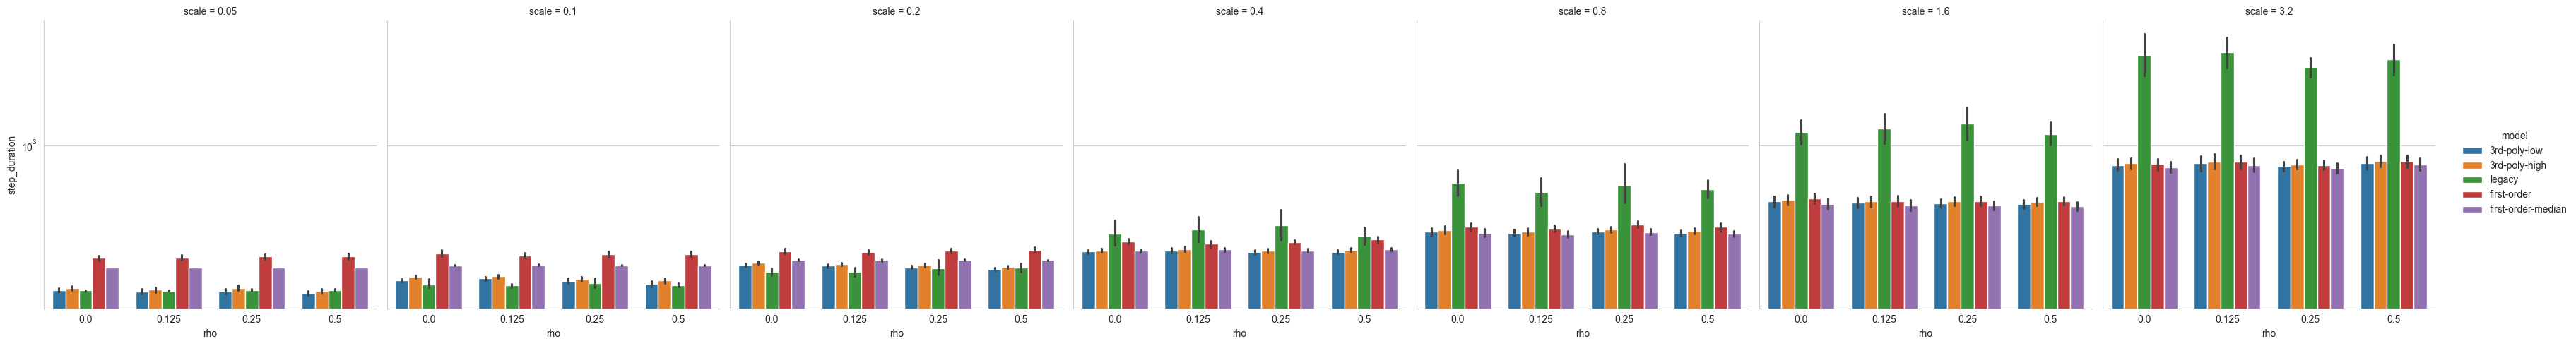

In [5]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

print("mean duration")
fg = sns.catplot(kind="bar", data=total_durations, hue="model", y="step_duration", col="scale", x="rho")
fg.set(yscale="log")
plt.show()

# push correlation higher

mean number of frames


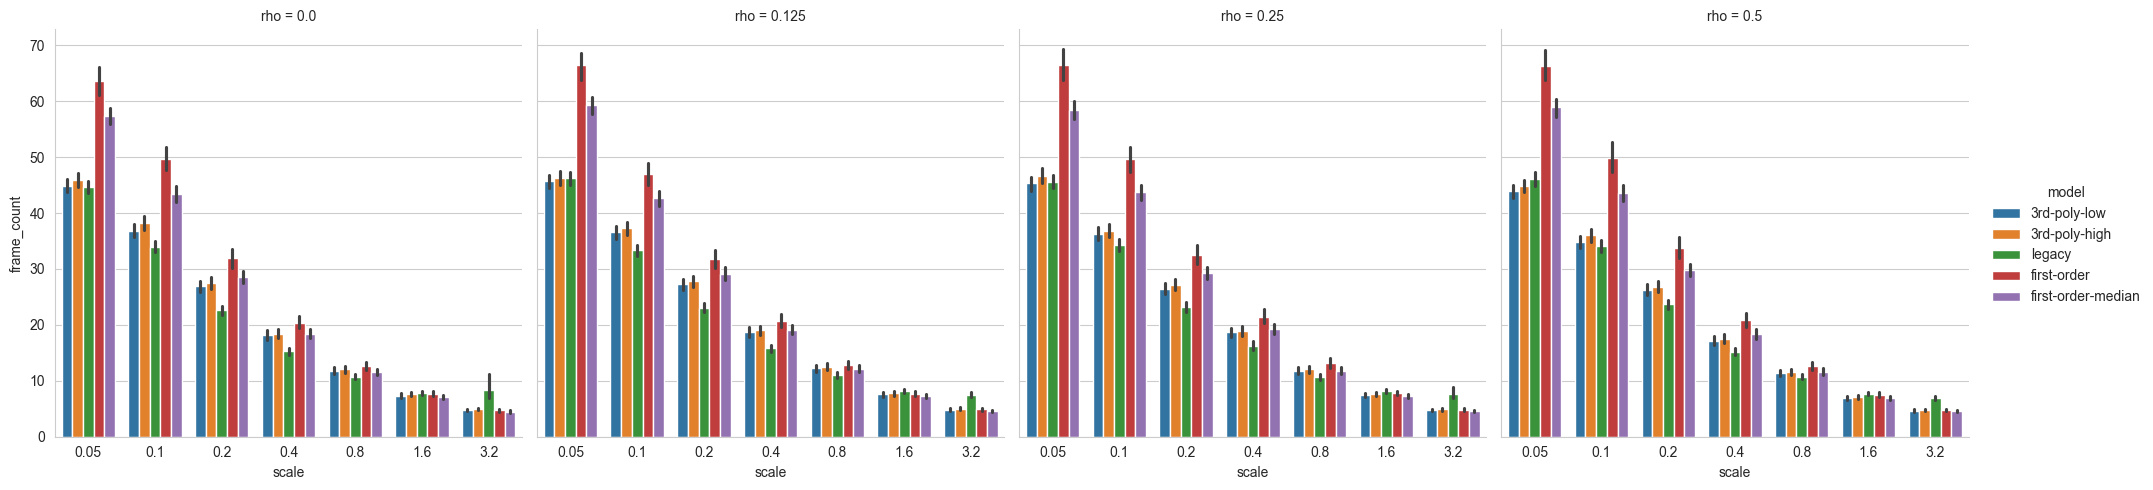

In [6]:
print("mean number of frames")
fg = sns.catplot(kind="bar", data=data, y="frame_count", hue="model", x="scale", col="rho")
plt.show()

mean TTF


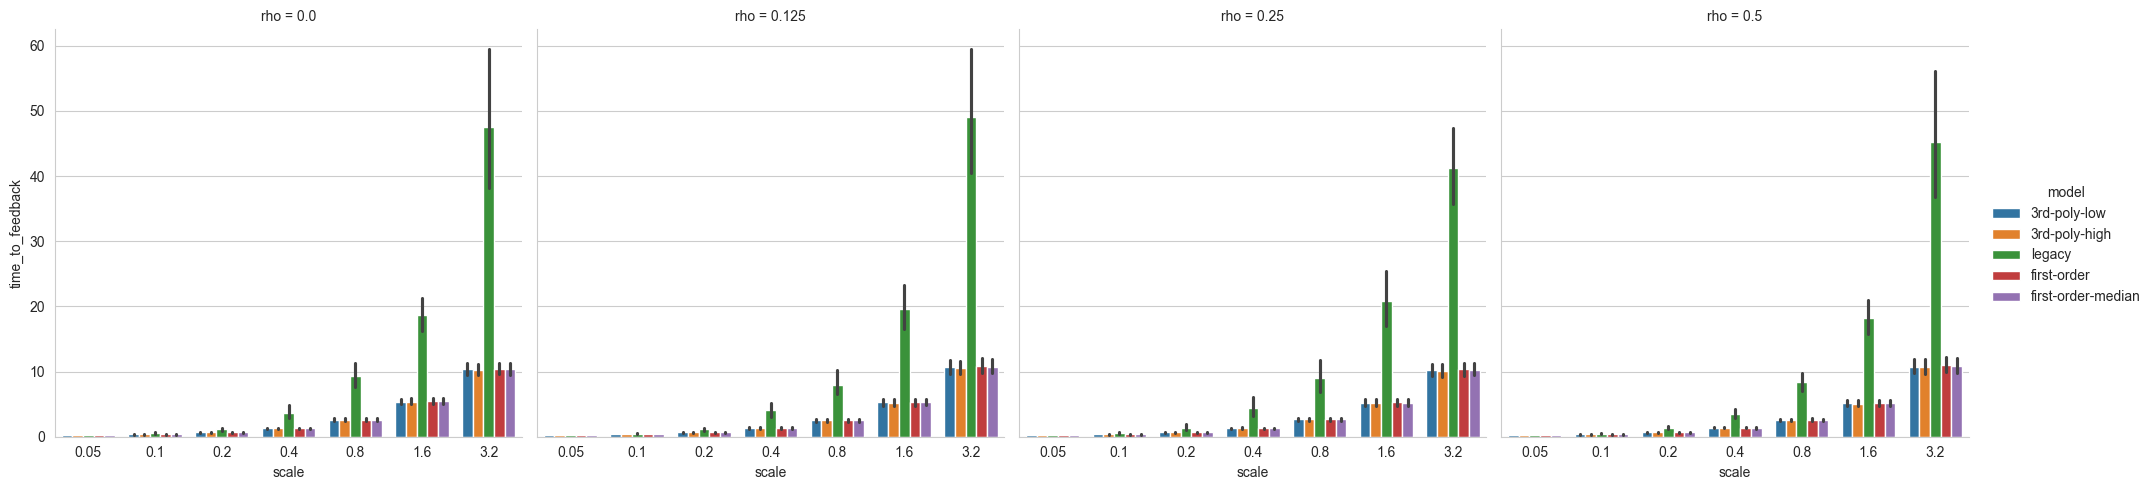

In [7]:
print("mean TTF")
fg = sns.catplot(kind="bar", data=data, hue="model", y="time_to_feedback", x="scale", col="rho")
plt.show()

mean wait time


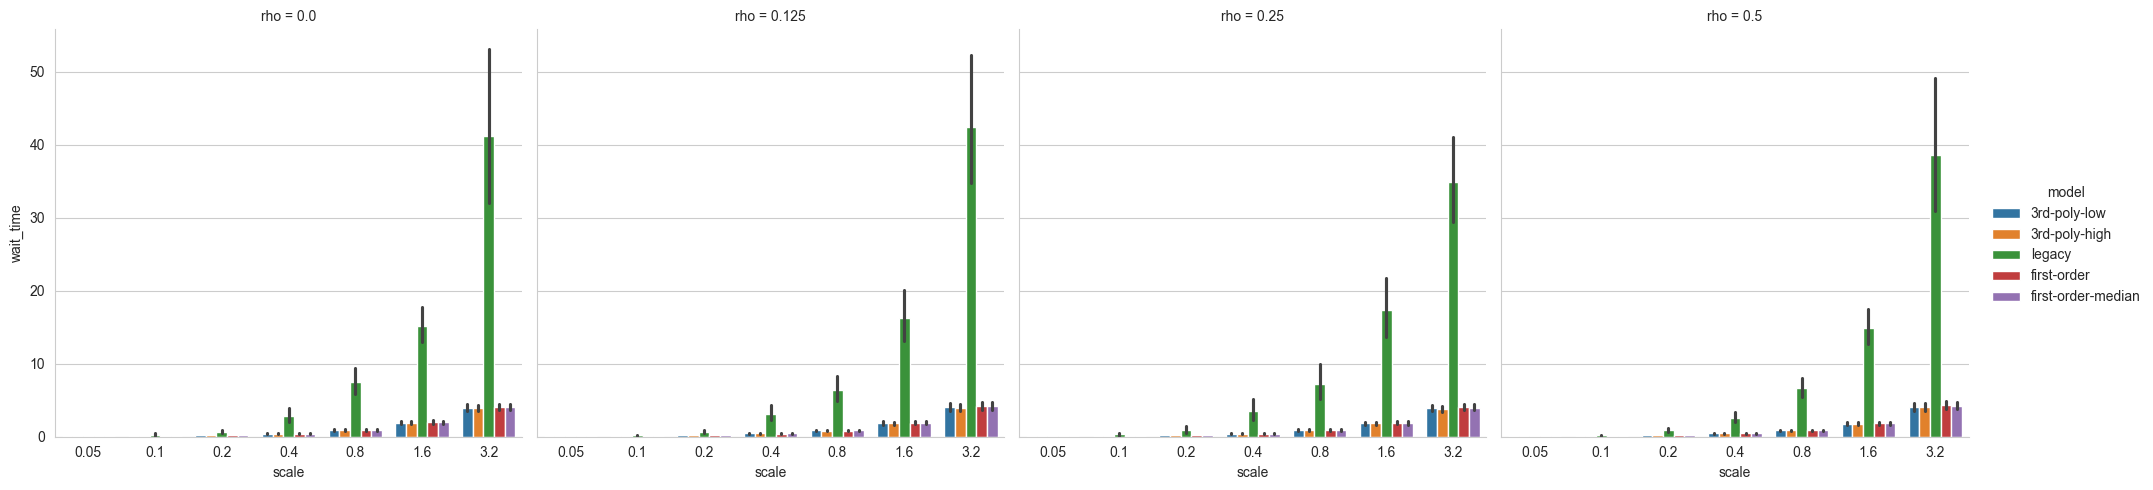

In [8]:
print("mean wait time")
fg = sns.catplot(kind="bar", data=data, hue="model", y="wait_time", x="scale", col="rho")
plt.show()

mean last frame rtt


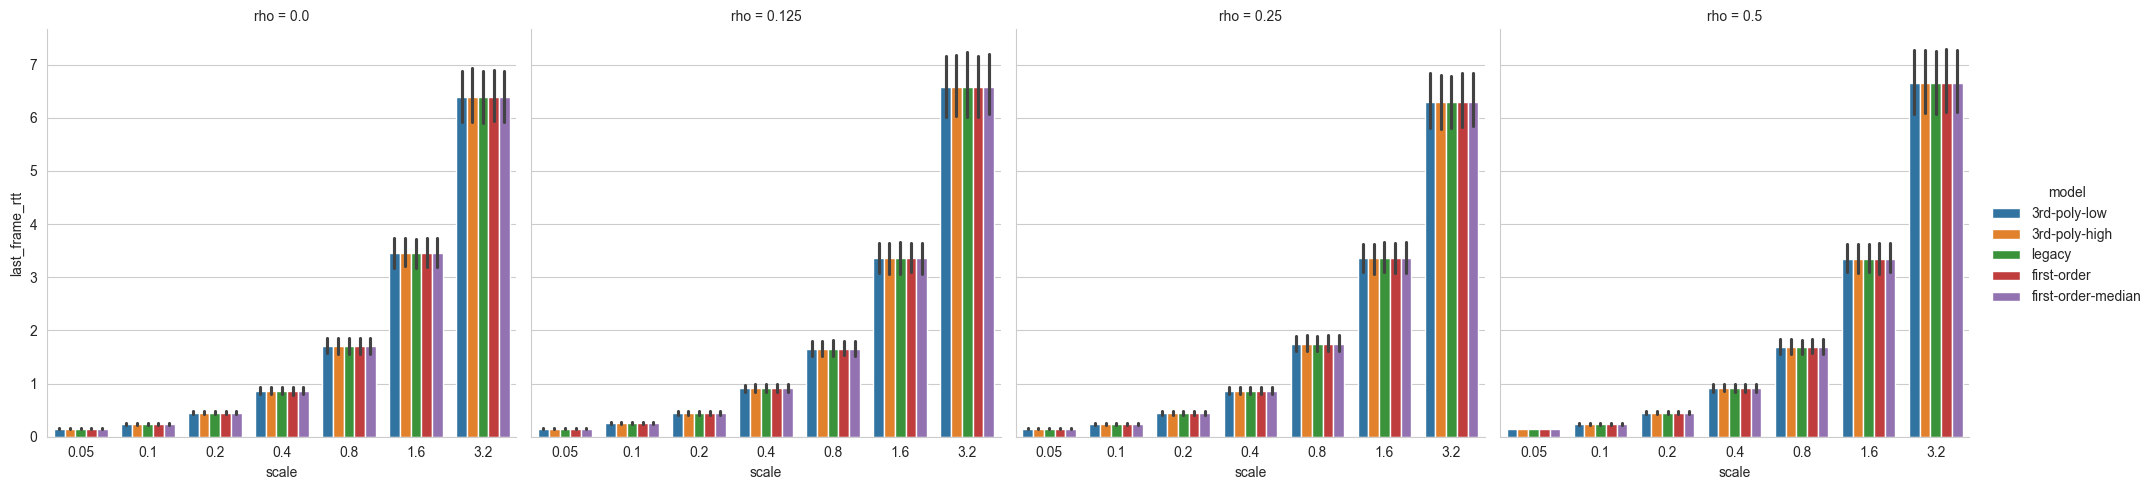

In [9]:
print("mean last frame rtt")
fg = sns.catplot(kind="bar", data=data, hue="model", y="last_frame_rtt", x="scale", col="rho")
plt.show()